# Load data and import library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=9e5c1c74b924a46248a1480132ec8764e935f83c7e6008fc847c27e01f2d6b2f
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [ ]:
def show(img, figsize=(8, 4), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

In [ ]:
X_filepath = '/content/drive/My Drive/Alternative Assessment/final_x.npy'
y_filepath = '/content/drive/My Drive/Alternative Assessment/final_y.npy'

X = np.load(X_filepath)
y = np.load(y_filepath)

print(X.shape)
print(y.shape)

(720, 28, 28)
(720,)


# Image Enhancement using Fuzzy Logic

In [ ]:
# Define fuzzy variable for pixel intensity
intensity = ctrl.Antecedent(np.arange(0, 256, 1), 'intensity')
# Define fuzzy variable for enhanced intensity
enhanced_intensity = ctrl.Consequent(np.arange(0, 256, 1), 'enhanced_intensity')

# Define membership functions for original intensity
intensity['dark'] = fuzz.trimf(intensity.universe, [0, 0, 128])
intensity['gray'] = fuzz.trimf(intensity.universe, [0, 128, 255])
intensity['bright'] = fuzz.trimf(intensity.universe, [128, 255, 255])

# Define membership functions for enhanced intensity
enhanced_intensity['darker'] = fuzz.trimf(enhanced_intensity.universe, [0, 0, 128])
enhanced_intensity['grayer'] = fuzz.trimf(enhanced_intensity.universe, [0, 128, 255])
enhanced_intensity['brighter'] = fuzz.trimf(enhanced_intensity.universe, [128, 255, 255])

In [ ]:
# Define fuzzy rules
rule1 = ctrl.Rule(intensity['dark'], enhanced_intensity['darker'])
rule2 = ctrl.Rule(intensity['gray'], enhanced_intensity['grayer'])
rule3 = ctrl.Rule(intensity['bright'], enhanced_intensity['brighter'])

# Create control system and simulation
fuzzy_control_system = ctrl.ControlSystem([rule1, rule2, rule3])
fuzzy_simulation = ctrl.ControlSystemSimulation(fuzzy_control_system)

In [ ]:
image = X
# Function to enhance the image using fuzzy logic
def enhance_image(image, fuzzy_simulation):
    enhanced_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            fuzzy_simulation.input['intensity'] = image[i, j]
            fuzzy_simulation.compute()
            enhanced_image[i, j] = fuzzy_simulation.output['enhanced_intensity']
    return enhanced_image

# Enhance the image
enhanced_image = enhance_image(image, fuzzy_simulation)

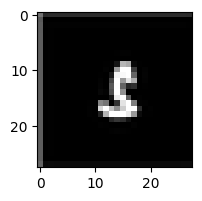

In [ ]:
show(image[400],figsize=(2,3))

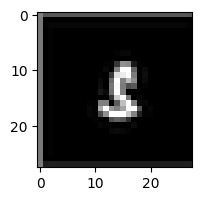

In [ ]:
show(enhanced_image[400],figsize=(2,3))

In [ ]:
label_mapping = {
    'Shun Qi': 0,
    'Carmen': 1,
    'Dernice': 2,
    'Shi Ting': 3,
    'Zia Qian': 4
}
y_mapped = np.array([label_mapping[label] for label in y])

# Neural Network (CNN)

In [ ]:
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
def create_cnn_model(learning_rate, num_neurons):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(num_neurons, activation='relu'),
        Dense(5, activation='softmax')  # 5 classes for 5 writers
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X = enhanced_image.reshape(-1, 28, 28, 1).astype('float32') / 255
y = to_categorical(y_mapped, 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and compile the model
model = create_cnn_model(learning_rate=0.001, num_neurons=128)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 693317 (2.64 MB)
Trainable params: 693317 (2.64 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
15/15 [==============================] - 2s 50ms/step - loss: 1.2257 - accuracy: 0.4913 - val_loss: 1.0394 - val_accuracy: 0.5172
Epoch 2/20
15/15 [==============================] - 1s 35ms/step - loss: 0.7180 - accuracy: 0.7152 - val_loss: 0.9115 - val_accuracy: 0.6379
Epoch 3/20
15/15 [==============================] - 0s 33ms/step - loss: 0.5993 - accuracy: 0.7500 - val_loss: 0.8876 - val_accuracy: 0.6293
Epoch 4/20
15/15 [==============================] - 0s 32ms/step - loss: 0.4636 - accuracy: 0.8043 - val_loss: 0.9129 - val_accuracy: 0.6379
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 0.4488 - accuracy: 0.8174 - val_loss: 0.7818 - val_accuracy: 0.7069
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 0.3681 - accuracy: 0.8565 - val_loss: 0.6946 - val_accuracy: 0.7241
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 0.3482 - accuracy: 0.8435 - val_loss: 0.7502 - val_accuracy: 0.7328
Epoch 8/20
15

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Test loss: 1.4532
Test accuracy: 0.7083


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

5/5 [==============================] - 0s 10ms/step


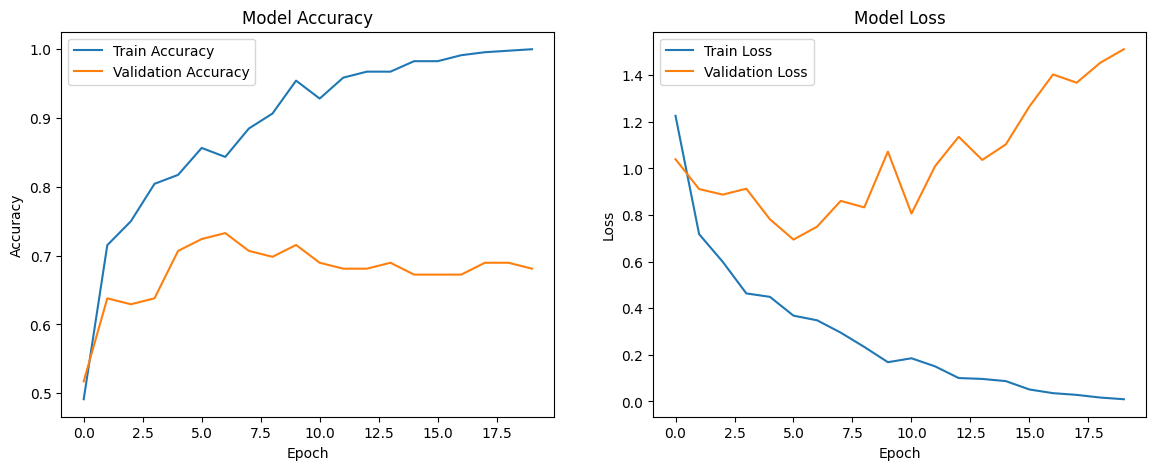

In [ ]:
# Plot training & validation accuracy and loss values
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# accuracy plot
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# loss plot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper left')

plt.show()

1. Classification Report

In [ ]:
report = classification_report(y_true, y_pred, target_names=list(label_mapping.keys()))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Shun Qi       0.73      0.47      0.57        34
      Carmen       0.80      0.77      0.78        26
     Dernice       0.89      0.86      0.87        36
    Shi Ting       0.64      0.73      0.68        22
    Zia Qian       0.51      0.73      0.60        26

    accuracy                           0.71       144
   macro avg       0.71      0.71      0.70       144
weighted avg       0.73      0.71      0.71       144



2. Confusion Matrix

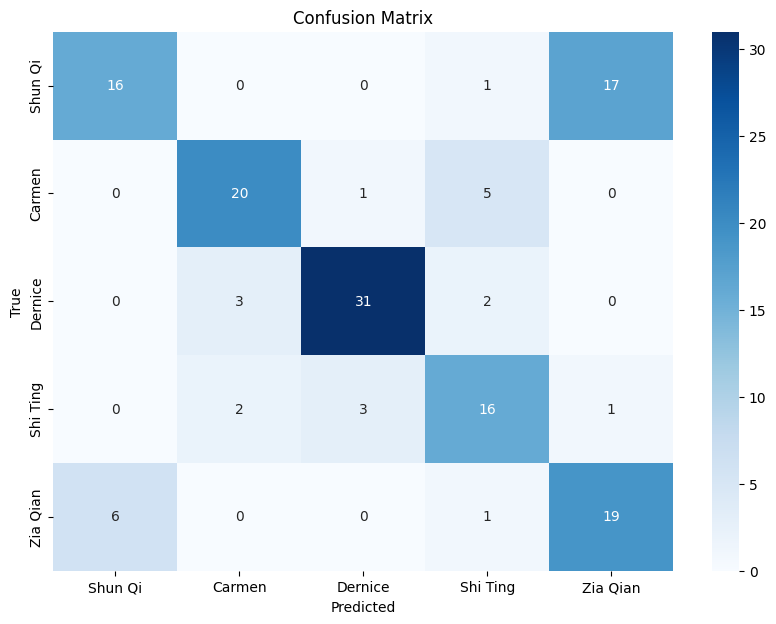

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

3. Total Number of Correct and Incorrect Predictions

In [ ]:
correct_predictions = np.sum(y_true == y_pred)
incorrect_predictions = np.sum(y_true != y_pred)

print(f"Total correct predictions: {correct_predictions}")
print(f"Total incorrect predictions: {incorrect_predictions}")

Total correct predictions: 102
Total incorrect predictions: 42


4. Accuracy of Each Class

In [ ]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, class_name in enumerate(label_mapping.keys()):
    print(f"Accuracy for {class_name}: {class_accuracy[idx]:.4f}")

Accuracy for Shun Qi: 0.4706
Accuracy for Carmen: 0.7692
Accuracy for Dernice: 0.8611
Accuracy for Shi Ting: 0.7273
Accuracy for Zia Qian: 0.7308


5. Classes with Best and Worst Accuracy

In [ ]:
best_class_index = np.argmax(class_accuracy)
worst_class_index = np.argmin(class_accuracy)

print(f"Class with best accuracy: {list(label_mapping.keys())[best_class_index]} ({class_accuracy[best_class_index]:.4f})")
print(f"Class with worst accuracy: {list(label_mapping.keys())[worst_class_index]} ({class_accuracy[worst_class_index]:.4f})")

Class with best accuracy: Dernice (0.8611)
Class with worst accuracy: Shun Qi (0.4706)


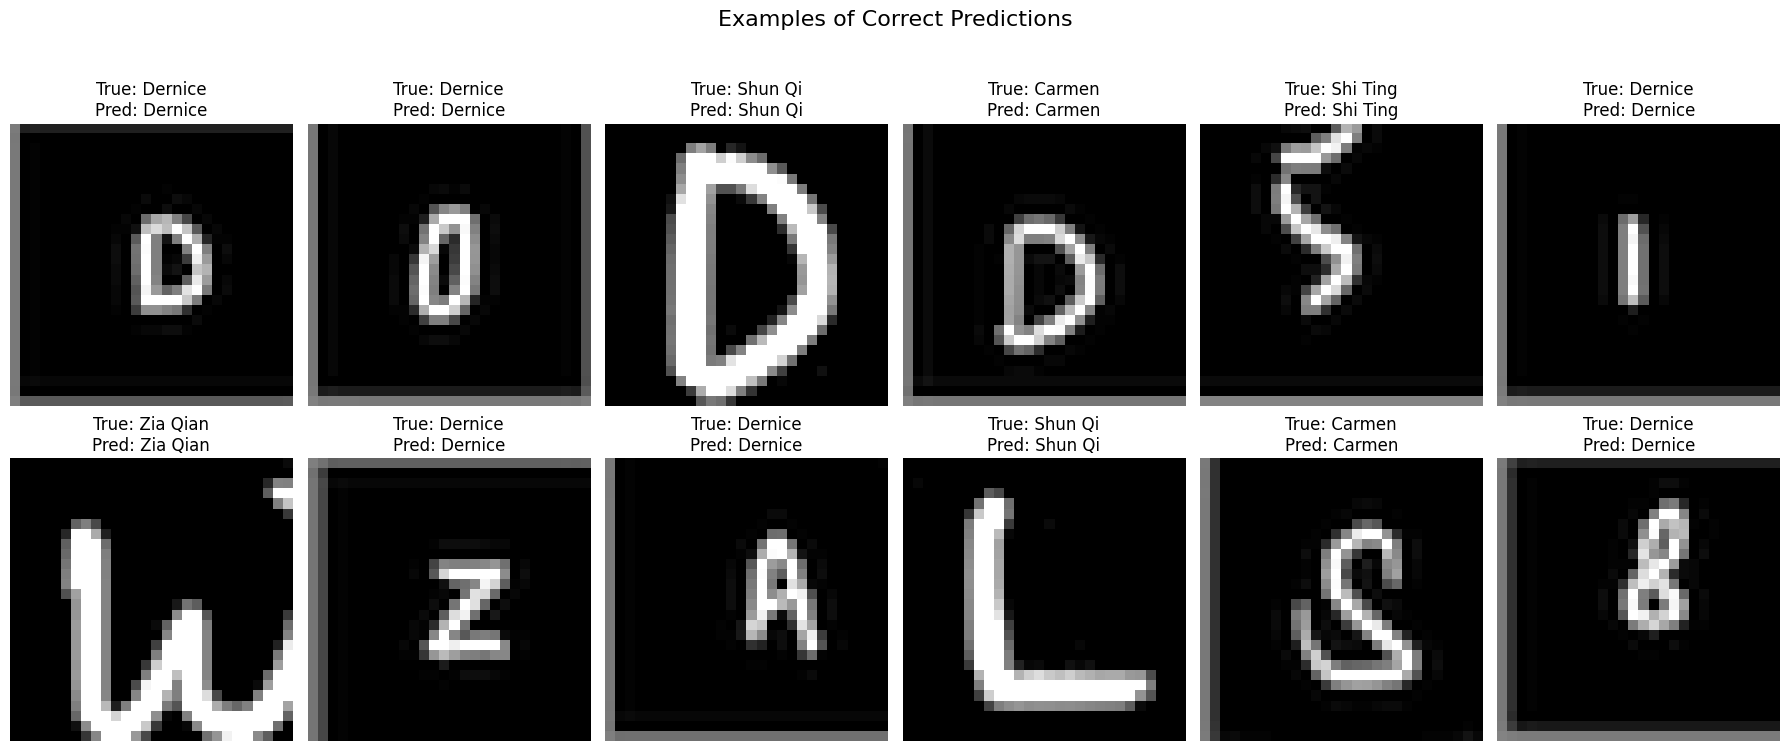

In [ ]:
# Find the correct indices
correct_indices = np.where(y_pred == y_true)[0]
correct_indices = correct_indices[:12]

# Plotting correct predictions
plt.figure(figsize=(18, 8))
plt.suptitle("Examples of Correct Predictions", fontsize=16)

for i, correct_idx in enumerate(correct_indices):
    plt.subplot(2, 6, i + 1)
    plt.imshow(X_test[correct_idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {list(label_mapping.keys())[y_true[correct_idx]]}\nPred: {list(label_mapping.keys())[y_pred[correct_idx]]}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

6. Show Examples of Correct and Incorrect Predictions

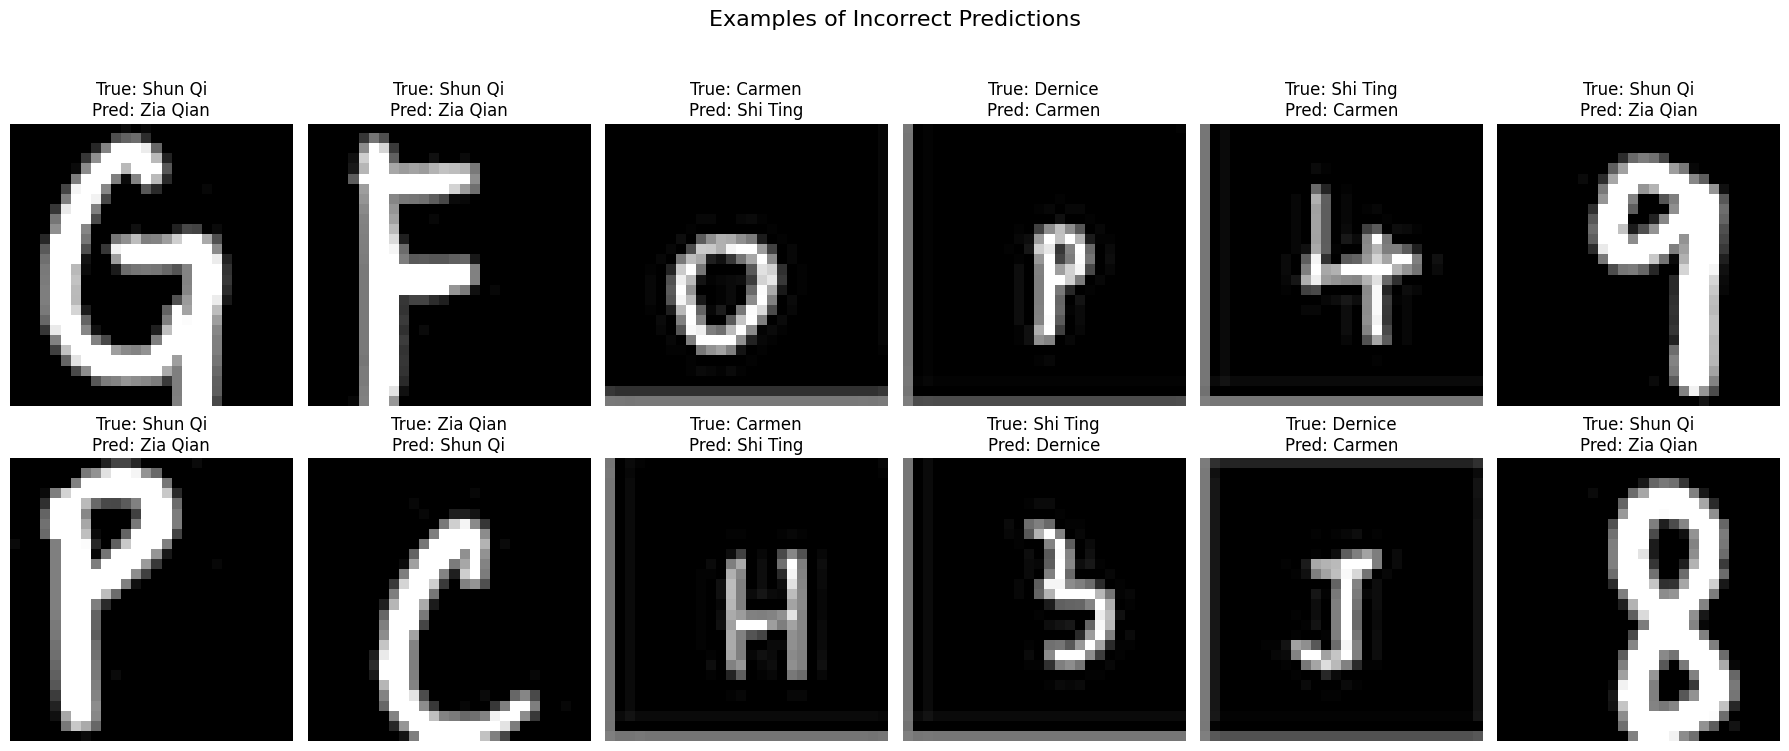

In [ ]:
incorrect_indices = np.where(y_pred != y_true)[0]
incorrect_indices = incorrect_indices[:12]

plt.figure(figsize=(18, 8))
plt.suptitle("Examples of Incorrect Predictions", fontsize=16)

for i, incorrect_idx in enumerate(incorrect_indices):
    plt.subplot(2, 6, i + 1)
    plt.imshow(X_test[incorrect_idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {list(label_mapping.keys())[y_true[incorrect_idx]]}\nPred: {list(label_mapping.keys())[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


7. Images with Best and Worst Accuracy

In [ ]:
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
# Calculate accuracy for each class
class_accuracies = {}
num_classes = y_test.shape[1]
for class_label in range(num_classes):
    class_indices = np.where(y_true == class_label)[0]
    if len(class_indices) > 0:
        class_correct = np.sum(y_pred[class_indices] == y_true[class_indices])
        class_accuracies[class_label] = class_correct / len(class_indices)
    else:
        class_accuracies[class_label] = 0.0

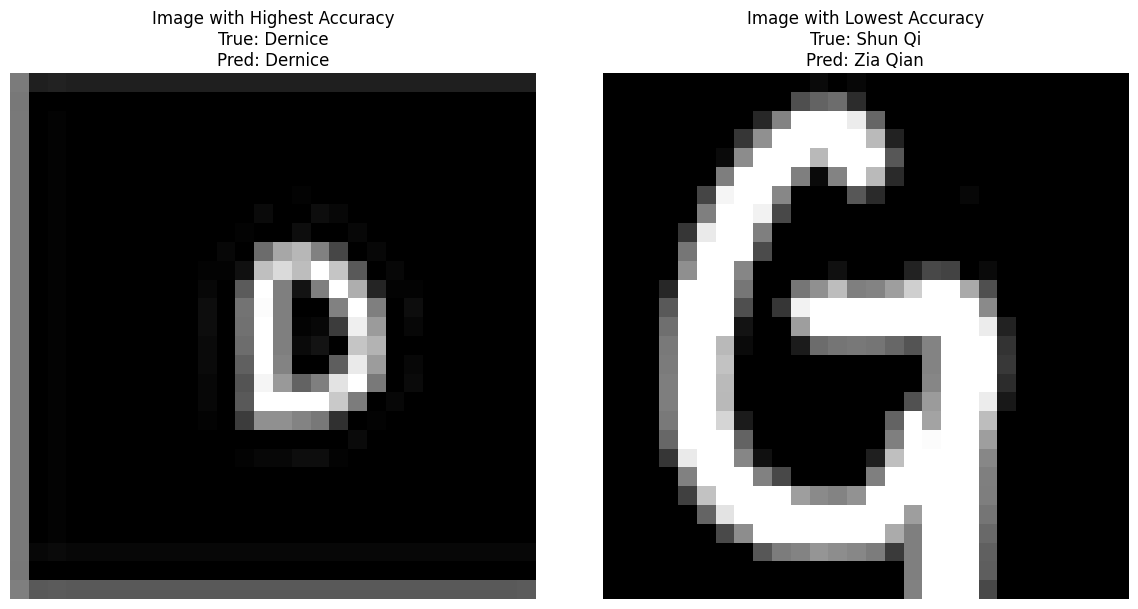

In [ ]:
best_accuracy_idx = np.argmax(list(class_accuracies.values()))
worst_accuracy_idx = np.argmin(list(class_accuracies.values()))

correct_best_idx = [idx for idx, label in enumerate(y_true) if label == best_accuracy_idx and y_pred[idx] == label][0]

incorrect_worst_idx = [idx for idx, label in enumerate(y_true) if label == worst_accuracy_idx and y_pred[idx] != label][0]

plt.figure(figsize=(12, 6))

# Plot the image with the highest accuracy
plt.subplot(1, 2, 1)
plt.imshow(X_test[correct_best_idx].reshape(28, 28), cmap='gray')
plt.title(f"Image with Highest Accuracy\nTrue: {reverse_label_mapping[y_true[correct_best_idx]]}\nPred: {reverse_label_mapping[y_pred[correct_best_idx]]}")
plt.axis('off')

# Plot the image with the lowest accuracy
plt.subplot(1, 2, 2)
plt.imshow(X_test[incorrect_worst_idx].reshape(28, 28), cmap='gray')
plt.title(f"Image with Lowest Accuracy\nTrue: {reverse_label_mapping[y_true[incorrect_worst_idx]]}\nPred: {reverse_label_mapping[y_pred[incorrect_worst_idx]]}")
plt.axis('off')

plt.tight_layout()
plt.show()

# SHAP (SHapley Additive exPlanations)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


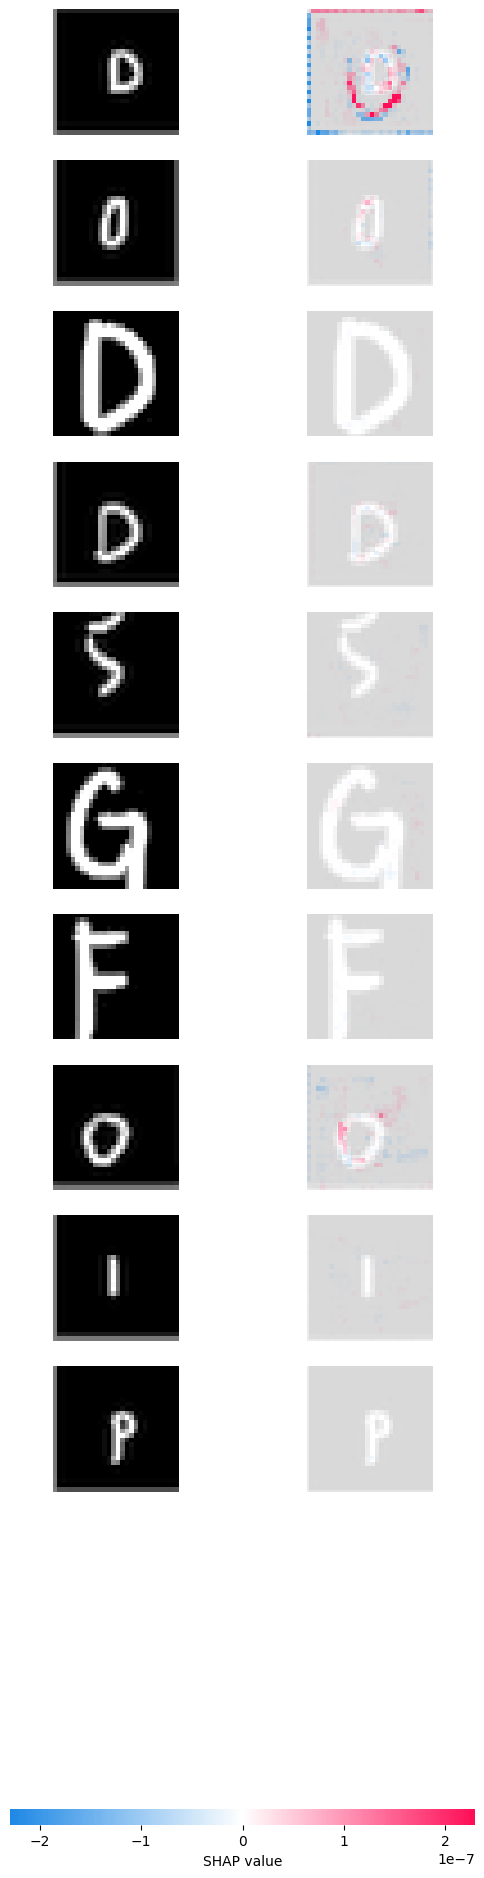

In [ ]:
import shap

explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

shap.image_plot(shap_values, X_test[:10])

# Saliency Map

True Class for Sample 1: Dernice
Predicted Class for Sample 1: Dernice
Prediction Confidence for Sample 1: 0.98


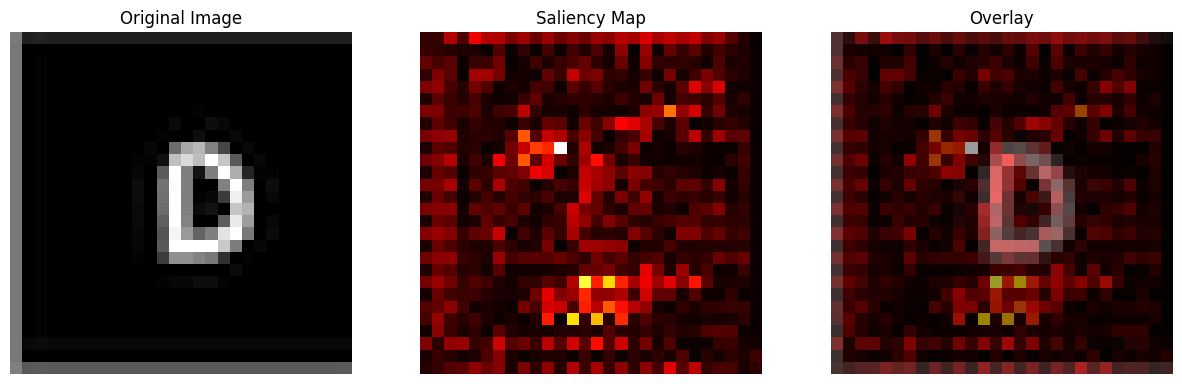

True Class for Sample 2: Dernice
Predicted Class for Sample 2: Dernice
Prediction Confidence for Sample 2: 0.84


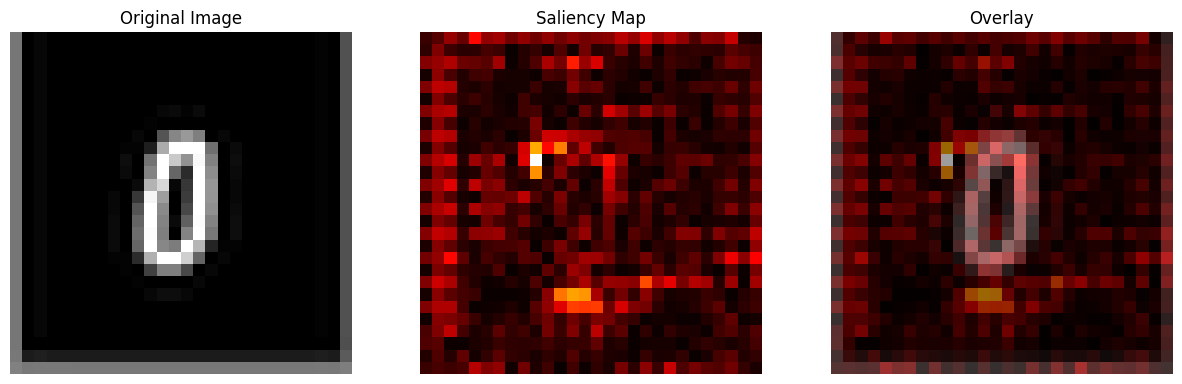

True Class for Sample 3: Shun Qi
Predicted Class for Sample 3: Shun Qi
Prediction Confidence for Sample 3: 0.98


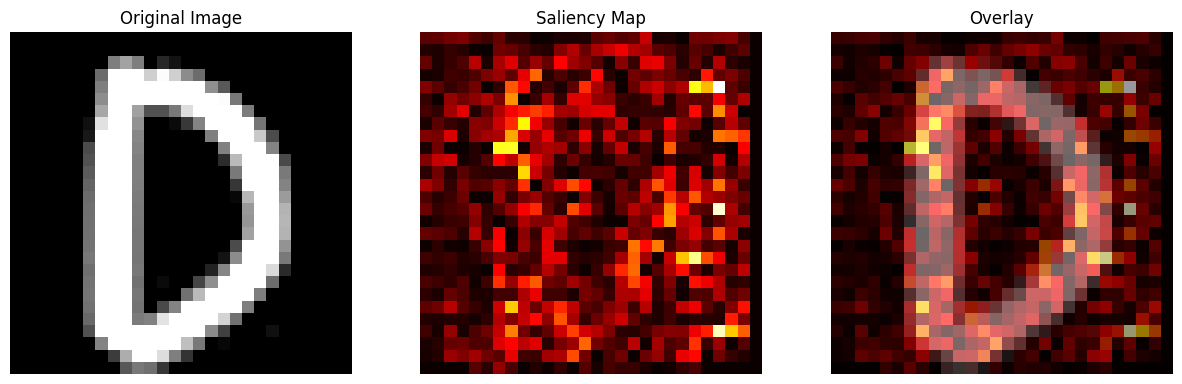

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_saliency_map(model, img):
    img = np.expand_dims(img, axis=0)
    img = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, img)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    return saliency[0], preds[0], top_pred_index

def plot_with_saliency(model, images, true_labels, class_names):
    for i, (img, true_label) in enumerate(zip(images, true_labels)):
        saliency, preds, top_pred_index = compute_saliency_map(model, img)

        true_label_index = np.argmax(true_label)

        print(f"True Class for Sample {i+1}: {class_names[true_label_index]}")
        print(f"Predicted Class for Sample {i+1}: {class_names[top_pred_index]}")
        print(f"Prediction Confidence for Sample {i+1}: {preds[top_pred_index].numpy():.2f}")

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(saliency, cmap='hot')
        ax[1].set_title('Saliency Map')
        ax[1].axis('off')

        ax[2].imshow(img, cmap='gray')
        ax[2].imshow(saliency, cmap='hot', alpha=0.6)
        ax[2].set_title('Overlay')
        ax[2].axis('off')

        plt.show()

images = X_test[:3]
true_labels = y_test[:3]
class_names = ['Shun Qi', 'Carmen', 'Dernice', 'Shi Ting', 'Zia Qian']
plot_with_saliency(model, images, true_labels, class_names)

In [ ]:
true_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# Optimization of CNN using Genetic Algorithm

In [ ]:
!pip install deap

In [ ]:
from deap import creator, base, tools, algorithms
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.activations import relu, sigmoid, tanh
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
import numpy as np

In [ ]:
# Define the CNN model creation function with additional parameters
def create_cnn_model(learning_rate, num_neurons, num_conv_layers, num_filters):
    num_conv_layers = int(num_conv_layers)
    num_filters = int(num_filters)
    num_neurons = max(1, int(num_neurons))
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    for _ in range(num_conv_layers - 1):
        model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(int(num_neurons), activation='relu'))
    model.add(Dense(5, activation='softmax'))  # 5 classes for 5 writers
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def evaluate_individual(individual):
    learning_rate, num_neurons, num_conv_layers, num_filters = individual
    model = create_cnn_model(learning_rate, num_neurons, num_conv_layers, num_filters)
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0, validation_split=0.1)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy,

In [ ]:
# GA setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.0001, 0.1)
toolbox.register("attr_int_neurons", random.randint, 32, 128)
toolbox.register("attr_int_layers", random.randint, 1, 3)
toolbox.register("attr_int_filters", random.randint, 16, 64)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_float, toolbox.attr_int_neurons, toolbox.attr_int_layers, toolbox.attr_int_filters), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.6
mutpb = 0.2

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max"

best_fitness = 0
generations_without_improvement = 0
stopping_generations = 10
elite_count = 2

In [ ]:
best_individual = None
generations_without_improvement = 0
all_generations_population = []

for gen in range(ngen):

    offspring = toolbox.select(population, len(population) - elite_count)
    offspring = list(map(toolbox.clone, offspring))
    elite = tools.selBest(population, k=elite_count)
    offspring.extend(elite)


    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring
    all_generations_population.append(population[:])

    record = stats.compile(population)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)
    print(logbook.stream)

    max_fitness_in_generation = record["max"]
    if max_fitness_in_generation > best_fitness:
        best_fitness = max_fitness_in_generation
        best_individual = tools.selBest(population, k=1)[0]
        generations_without_improvement = 0
    else:
        generations_without_improvement += 1

    if generations_without_improvement >= stopping_generations:
        print(f"Stopping early: No improvement in {stopping_generations} generations.")
        break

gen	evals	std     	min     	avg     	max     
0  	20   	0.213688	0.152778	0.311111	0.722222
1  	14   	0.250868	0.152778	0.439583	0.75    
2  	14   	0.22835 	0.152778	0.580208	0.75    
3  	18   	0.164049	0.152778	0.642014	0.763889
4  	14   	0.123303	0.180556	0.686111	0.784722
5  	10   	0.131569	0.152778	0.711806	0.784722
6  	18   	0.108018	0.25    	0.697569	0.784722
7  	12   	0.126043	0.180556	0.700347	0.784722
8  	10   	0.124973	0.180556	0.713889	0.784722
9  	14   	0.16468 	0.152778	0.676736	0.784722
10 	11   	0.0486557	0.590278	0.729861	0.784722
11 	16   	0.0318897	0.652778	0.734375	0.784722
12 	16   	0.109821 	0.25    	0.714583	0.791667
13 	17   	0.164313 	0.152778	0.680208	0.791667
14 	12   	0.131942 	0.152778	0.706597	0.791667
15 	16   	0.0257858	0.708333	0.734375	0.798611
16 	11   	0.037026 	0.673611	0.742014	0.798611
17 	16   	0.149619 	0.25    	0.686806	0.777778
18 	16   	0.203216 	0.152778	0.655208	0.784722
19 	11   	0.170725 	0.152778	0.700694	0.784722


In [ ]:
if best_individual is not None:
    print(f"Best Individual found: {best_individual}, Fitness: {best_fitness}")
else:
    print("No individual with valid fitness found.")

Best Individual found: [0.006180326288790958, 39.655205314418446, -0.6458489863187389, 46.01544407040442], Fitness: 0.7986111044883728


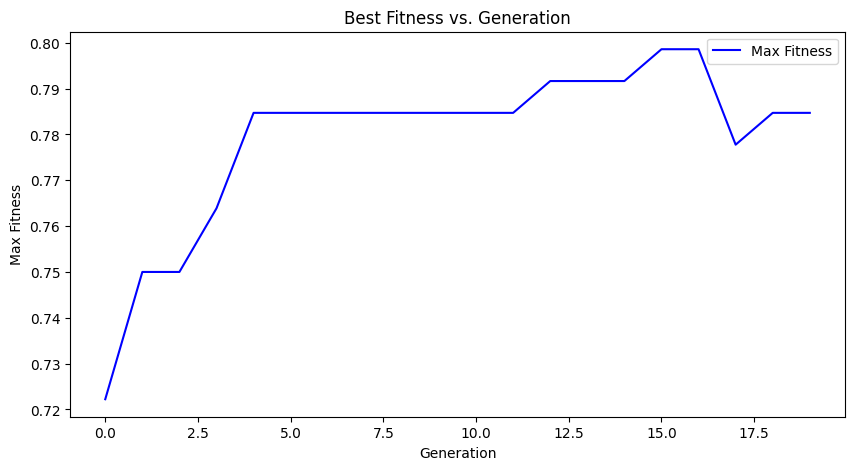

In [ ]:
gen = logbook.select("gen")
max_fit = logbook.select("max")
plt.figure(figsize=(10, 5))
plt.plot(gen, max_fit, 'b-', label='Max Fitness')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.title('Best Fitness vs. Generation')
plt.legend(loc='best')
plt.show()

In [ ]:
print("\nFinal Population:")
for ind in population:
    print(ind)


Final Population:
[0.00623639927400018, 39.65648130381153, 0.37065911231832604, 43.612748679237484]
[0.006158867156926084, 39.65541936076825, 0.36276623600464886, 43.840971394968236]
[0.006177489374538821, 39.65310975480277, 0.33352363425561277, 44.83818644297622]
[0.006174936130842011, 39.65305169514378, 0.3079967333392638, 43.5097571277508]
[0.00617768829936589, 39.65240411577415, 0.3463156293249317, 44.8244433242659]
[0.006177466166282874, 39.652595145697944, 0.24801281365472477, 43.09507418385463]
[0.006174993874335439, 39.65318538909425, 0.35841992015925156, 43.816272910268]
[0.006174993874335439, 39.65318538909425, 0.14406806864303578, 43.816272910268]
[0.006174993874335439, 39.65318538909425, 0.35841992015925156, 43.816272910268]
[0.006174993874335439, 39.65318538909425, 0.35841992015925156, 43.816272910268]
[0.7836080258962236, 40.2259002446741, 0.3634216827249334, 42.92594290963697]
[0.006168189689741468, 39.65349693035489, 0.34566018260464715, 44.9702314952581]
[0.3634370556

In [ ]:
print("\nGene Representation:")
print("Gene 1: Learning Rate")
print("Gene 2: Number of Neurons in Dense Layer")
print("Gene 3: Number of Convolutional Layers")
print("Gene 4: Number of Filters per Convolutional Layer")


Gene Representation:
Gene 1: Learning Rate
Gene 2: Number of Neurons in Dense Layer
Gene 3: Number of Convolutional Layers
Gene 4: Number of Filters per Convolutional Layer


# Optimized Neural Network (CNN) Classifier using best individual from genetic algorithm

In [ ]:
def create_cnn_model(learning_rate, num_neurons, num_conv_layers, num_filters):
    num_conv_layers = int(num_conv_layers)
    num_filters = int(num_filters)
    num_neurons = max(1, int(num_neurons))
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    for _ in range(num_conv_layers - 1):
        model.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(int(num_neurons), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
learning_rate = best_individual[0]
num_neurons = best_individual[1]
num_conv_layers = best_individual[2]
num_filters = best_individual[3]

optimized_model = create_cnn_model(learning_rate, num_neurons, num_conv_layers, num_filters)

In [ ]:
optimized_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 46)        460       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 46)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 7774)              0         
                                                                 
 dense_2 (Dense)             (None, 39)                303225    
                                                                 
 dense_3 (Dense)             (None, 5)                 200       
                                                                 
Total params: 303885 (1.16 MB)
Trainable params: 303885 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
# Train the model
optimized = optimized_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
15/15 [==============================] - 2s 49ms/step - loss: 1.3649 - accuracy: 0.4413 - val_loss: 1.0374 - val_accuracy: 0.6379
Epoch 2/20
15/15 [==============================] - 0s 20ms/step - loss: 0.8710 - accuracy: 0.6978 - val_loss: 0.8107 - val_accuracy: 0.7414
Epoch 3/20
15/15 [==============================] - 0s 21ms/step - loss: 0.7060 - accuracy: 0.6978 - val_loss: 0.8302 - val_accuracy: 0.7069
Epoch 4/20
15/15 [==============================] - 0s 21ms/step - loss: 0.6325 - accuracy: 0.7522 - val_loss: 0.9122 - val_accuracy: 0.6379
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 0.5587 - accuracy: 0.7957 - val_loss: 0.7372 - val_accuracy: 0.7155
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 0.4763 - accuracy: 0.8457 - val_loss: 0.7259 - val_accuracy: 0.7328
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 0.4464 - accuracy: 0.8304 - val_loss: 0.7973 - val_accuracy: 0.6983
Epoch 8/20
15

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = optimized_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Test loss: 0.6760
Test accuracy: 0.7500


In [ ]:
y_pred_prob = optimized_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

5/5 [==============================] - 0s 21ms/step


In [ ]:
report = classification_report(y_true, y_pred, target_names=list(label_mapping.keys()))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Shun Qi       0.77      0.71      0.74        34
      Carmen       0.70      0.88      0.78        26
     Dernice       0.90      0.75      0.82        36
    Shi Ting       0.67      0.73      0.70        22
    Zia Qian       0.69      0.69      0.69        26

    accuracy                           0.75       144
   macro avg       0.75      0.75      0.74       144
weighted avg       0.76      0.75      0.75       144



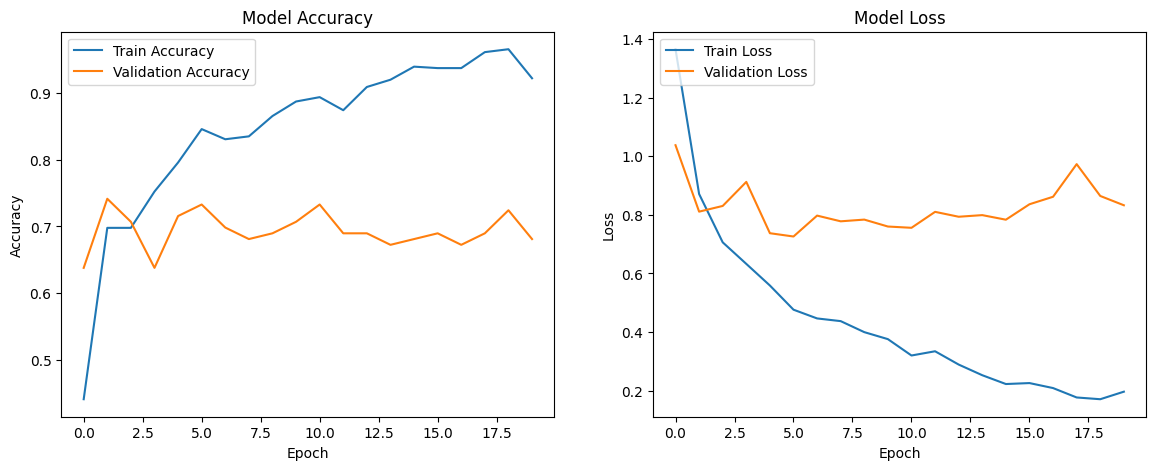

In [ ]:
# Plot training & validation accuracy and loss values
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax[0].plot(optimized.history['accuracy'], label='Train Accuracy')
ax[0].plot(optimized.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# Plot loss
ax[1].plot(optimized.history['loss'], label='Train Loss')
ax[1].plot(optimized.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper left')

plt.show()

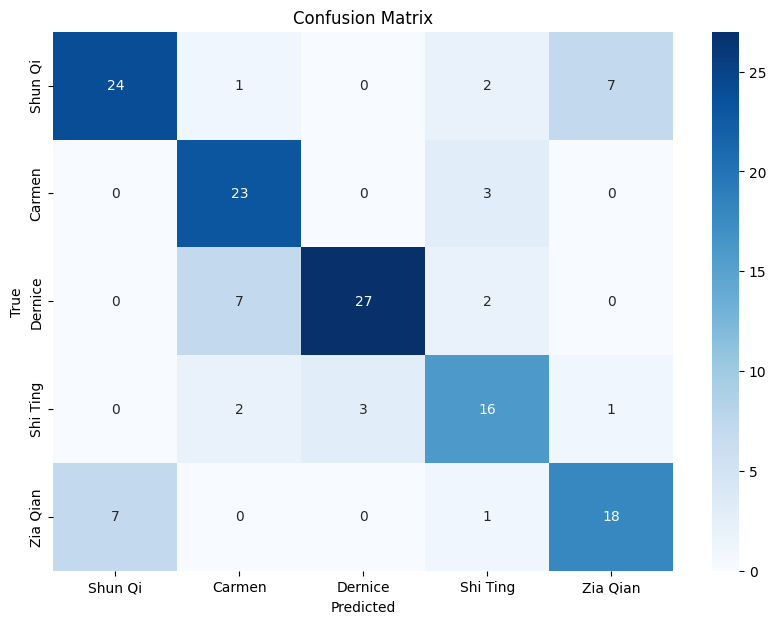

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
correct_predictions = np.sum(y_true == y_pred)
incorrect_predictions = np.sum(y_true != y_pred)

print(f"Total correct predictions: {correct_predictions}")
print(f"Total incorrect predictions: {incorrect_predictions}")

Total correct predictions: 108
Total incorrect predictions: 36


In [ ]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, class_name in enumerate(label_mapping.keys()):
    print(f"Accuracy for {class_name}: {class_accuracy[idx]:.4f}")

Accuracy for Shun Qi: 0.7059
Accuracy for Carmen: 0.8846
Accuracy for Dernice: 0.7500
Accuracy for Shi Ting: 0.7273
Accuracy for Zia Qian: 0.6923


In [ ]:
best_class_index = np.argmax(class_accuracy)
worst_class_index = np.argmin(class_accuracy)

print(f"Class with best accuracy: {list(label_mapping.keys())[best_class_index]} ({class_accuracy[best_class_index]:.4f})")
print(f"Class with worst accuracy: {list(label_mapping.keys())[worst_class_index]} ({class_accuracy[worst_class_index]:.4f})")


Class with best accuracy: Carmen (0.8846)
Class with worst accuracy: Zia Qian (0.6923)


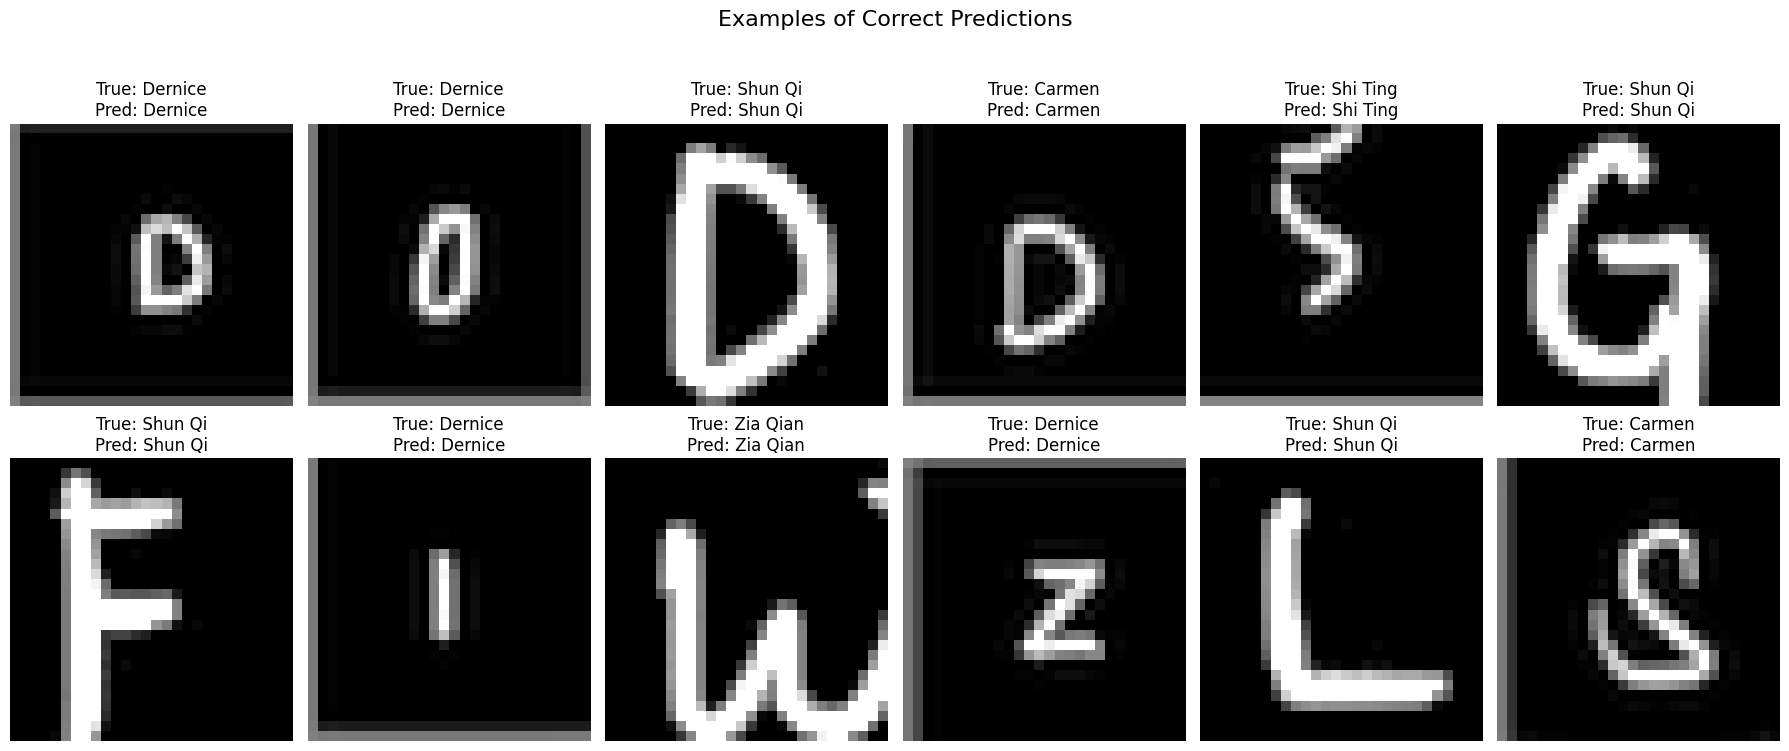

In [ ]:
correct_indices = np.where(y_pred == y_true)[0]
correct_indices = correct_indices[:12]

# Plotting correct predictions
plt.figure(figsize=(18, 8))
plt.suptitle("Examples of Correct Predictions", fontsize=16)

for i, correct_idx in enumerate(correct_indices):
    plt.subplot(2, 6, i + 1)
    plt.imshow(X_test[correct_idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {list(label_mapping.keys())[y_true[correct_idx]]}\nPred: {list(label_mapping.keys())[y_pred[correct_idx]]}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

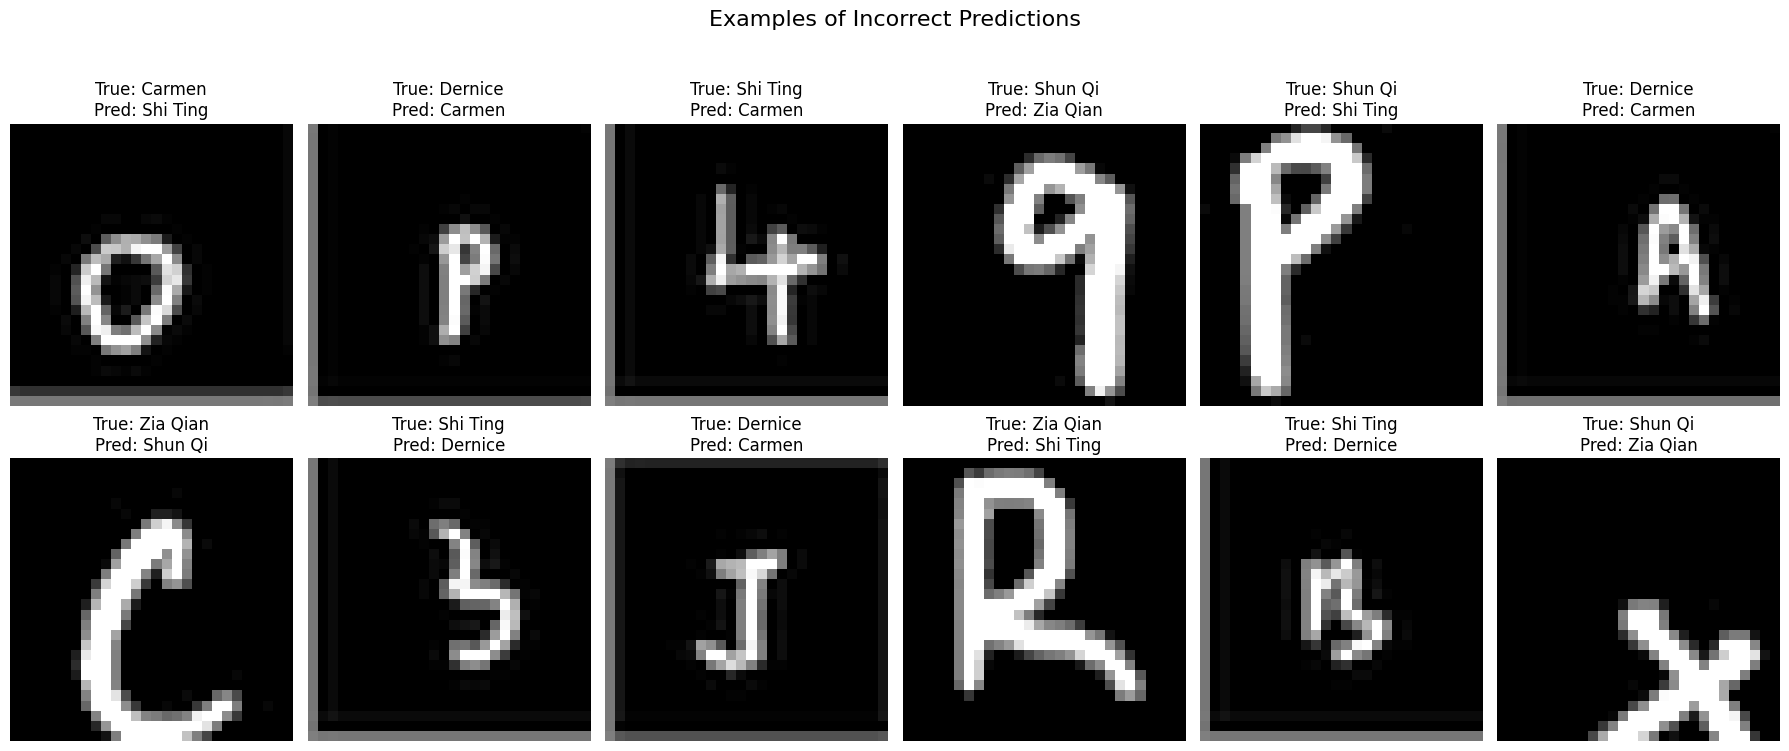

In [ ]:
incorrect_indices = np.where(y_pred != y_true)[0]
incorrect_indices = incorrect_indices[:12]

plt.figure(figsize=(18, 8))
plt.suptitle("Examples of Incorrect Predictions", fontsize=16)

for i, incorrect_idx in enumerate(incorrect_indices):
    plt.subplot(2, 6, i + 1)
    plt.imshow(X_test[incorrect_idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {list(label_mapping.keys())[y_true[incorrect_idx]]}\nPred: {list(label_mapping.keys())[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
# Calculate accuracy for each class
class_accuracies = {}
num_classes = y_test.shape[1]
for class_label in range(num_classes):
    class_indices = np.where(y_true == class_label)[0]
    if len(class_indices) > 0:
        class_correct = np.sum(y_pred[class_indices] == y_true[class_indices])
        class_accuracies[class_label] = class_correct / len(class_indices)
    else:
        class_accuracies[class_label] = 0.0

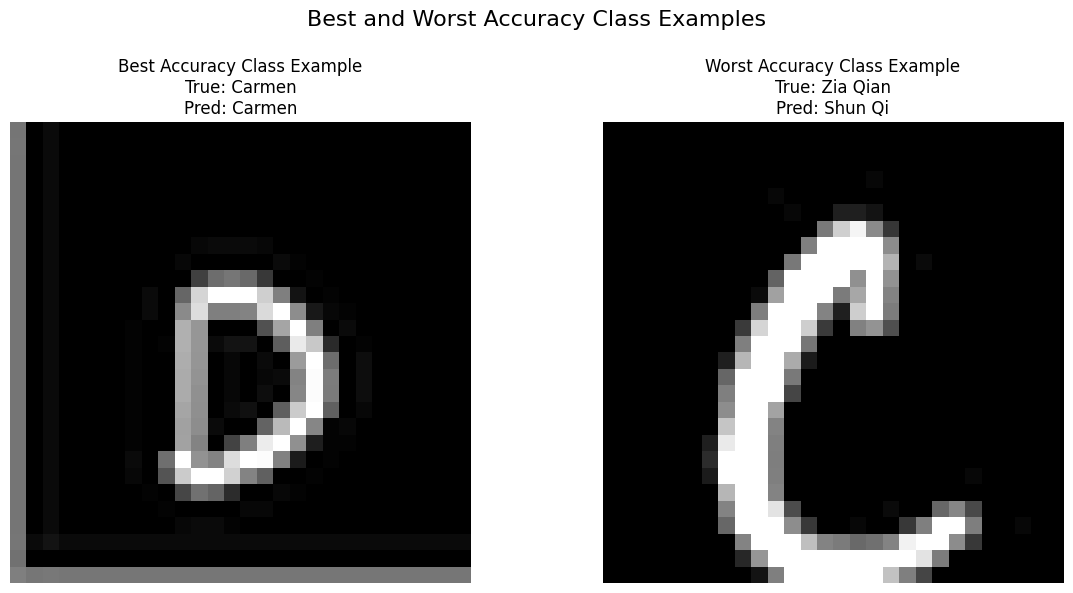

In [ ]:
correct_best_idx = [idx for idx in best_class_indices if y_true[idx] == y_pred[idx]][0]

incorrect_worst_idx = [idx for idx in worst_class_indices if y_true[idx] != y_pred[idx]][0]

plt.figure(figsize=(12, 6))
plt.suptitle("Best and Worst Accuracy Class Examples", fontsize=16)

# Best accuracy class example
plt.subplot(1, 2, 1)
plt.imshow(X_test[correct_best_idx].reshape(28, 28), cmap='gray')
plt.title(f"Best Accuracy Class Example\nTrue: {list(label_mapping.keys())[y_true[correct_best_idx]]}\nPred: {list(label_mapping.keys())[y_pred[correct_best_idx]]}")
plt.axis('off')

# Worst accuracy class example
plt.subplot(1, 2, 2)
plt.imshow(X_test[incorrect_worst_idx].reshape(28, 28), cmap='gray')
plt.title(f"Worst Accuracy Class Example\nTrue: {list(label_mapping.keys())[y_true[incorrect_worst_idx]]}\nPred: {list(label_mapping.keys())[y_pred[incorrect_worst_idx]]}")
plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# SHAP For Optimized Model

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


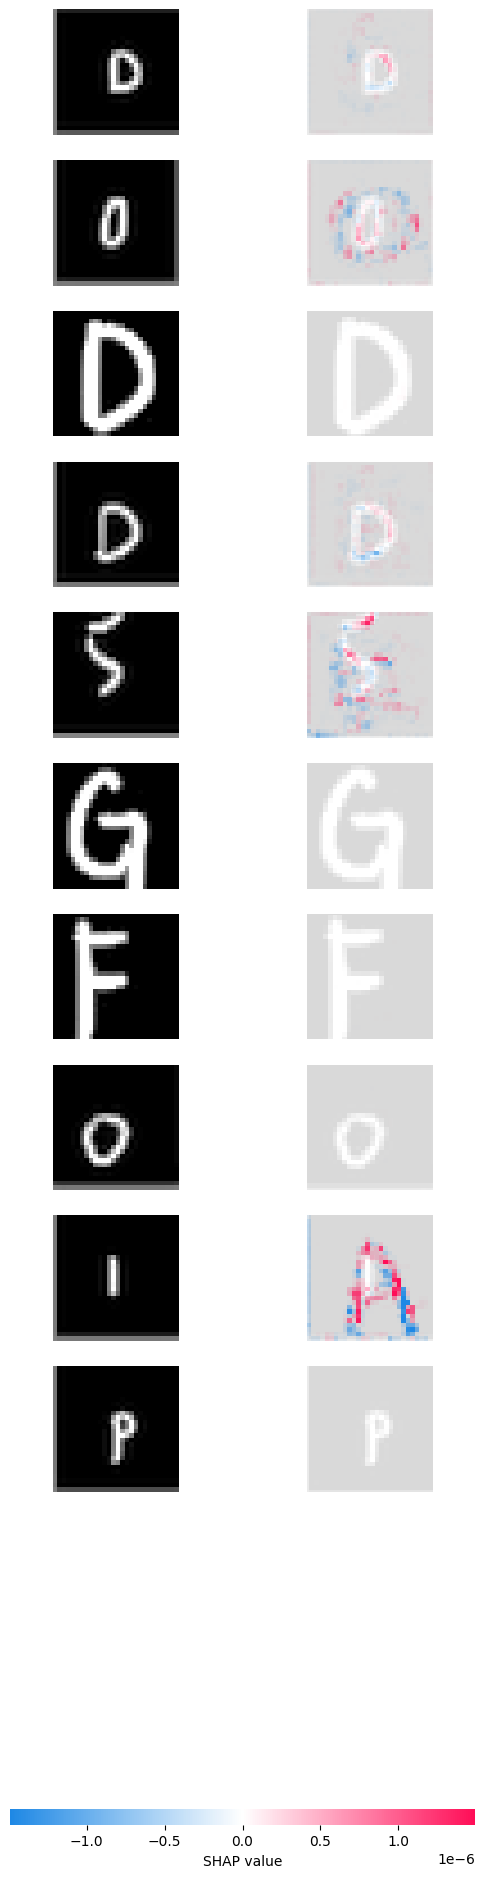

In [ ]:
import shap

explainer = shap.DeepExplainer(optimized_model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

shap.image_plot(shap_values, X_test[:10])

# Saliency Map for Optimized Model

True Class for Sample 1: Dernice
Predicted Class for Sample 1: Dernice
Prediction Confidence for Sample 1: 1.00


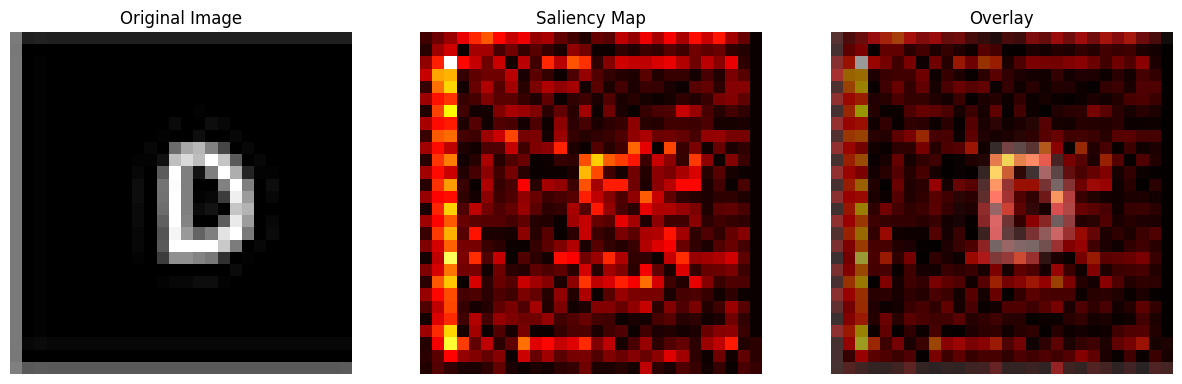

True Class for Sample 2: Dernice
Predicted Class for Sample 2: Dernice
Prediction Confidence for Sample 2: 1.00


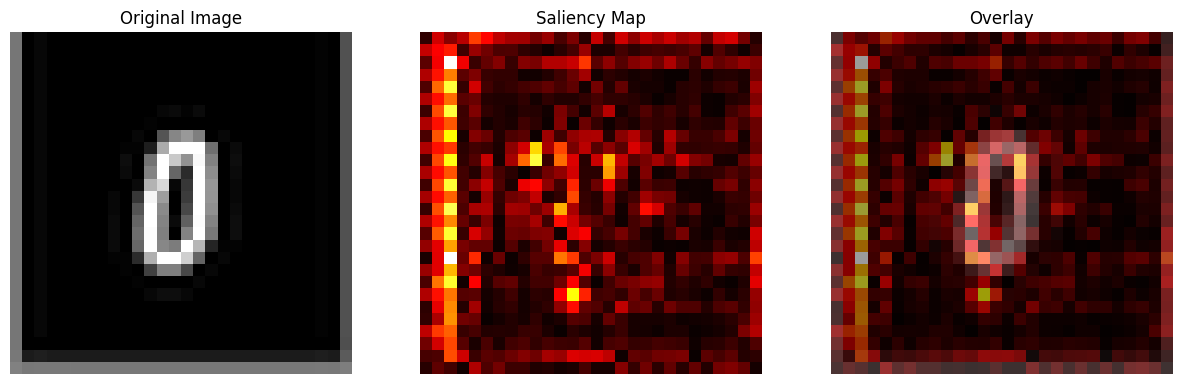

True Class for Sample 3: Shun Qi
Predicted Class for Sample 3: Shun Qi
Prediction Confidence for Sample 3: 0.98


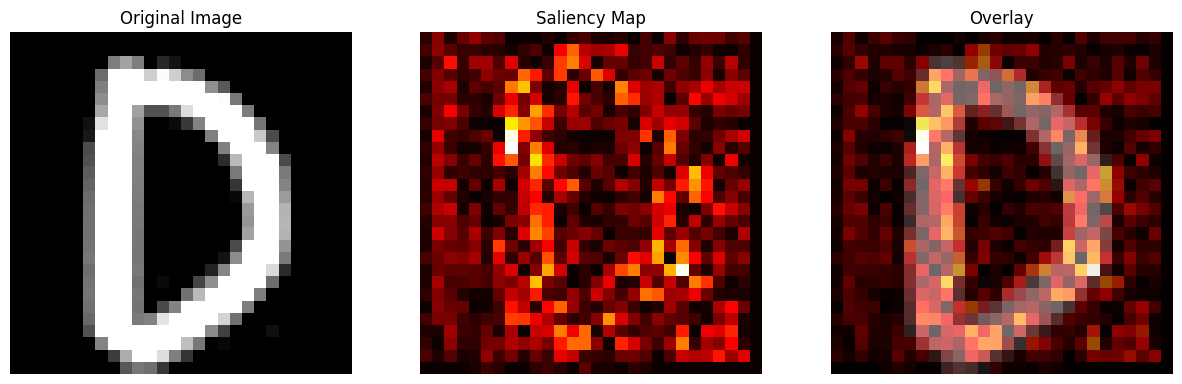

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_saliency_map(model, img):
    img = np.expand_dims(img, axis=0)
    img = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, img)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    return saliency[0], preds[0], top_pred_index

def plot_with_saliency(model, images, true_labels, class_names):
    for i, (img, true_label) in enumerate(zip(images, true_labels)):
        saliency, preds, top_pred_index = compute_saliency_map(model, img)

        true_label_index = np.argmax(true_label)

        print(f"True Class for Sample {i+1}: {class_names[true_label_index]}")
        print(f"Predicted Class for Sample {i+1}: {class_names[top_pred_index]}")
        print(f"Prediction Confidence for Sample {i+1}: {preds[top_pred_index].numpy():.2f}")

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(saliency, cmap='hot')
        ax[1].set_title('Saliency Map')
        ax[1].axis('off')

        ax[2].imshow(img, cmap='gray')
        ax[2].imshow(saliency, cmap='hot', alpha=0.6)
        ax[2].set_title('Overlay')
        ax[2].axis('off')

        plt.show()

images = X_test[:3]
true_labels = y_test[:3]
class_names = ['Shun Qi', 'Carmen', 'Dernice', 'Shi Ting', 'Zia Qian']
plot_with_saliency(optimized_model, images, true_labels, class_names)